In [1]:
import torch
import os, sys
import numpy as np
parent_dir = os.path.abspath('../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
os.environ['CUDA_VISIBLE_DEVICES']='0'
from torch.nn.functional import pad,fold
from util.util import kbdwin

In [ ]:
a = torch.arange(start=0, end=16,step=1, dtype=torch.float64)
exp = torch.exp(-2j*torch.pi/16*(torch.arange(start=0, end=16//4,step=1, dtype=torch.float64)+1/8))
print(exp)
a = (a[...,:16//2:2]-a[...,1+16//2::2].flip(-1)) - 1j*(a[...,16//2::2]-a[...,1:16//2:2].flip(-1))
print(a)
a = a*exp
a = torch.fft.fft(a)
a = a*exp
print(a)
a = 2/torch.sqrt(torch.tensor(16))*torch.view_as_real(a)
print(a)
a[...,1] = -a[...,1].flip(-1)
a = a.flatten(-2)
print(a)


In [ ]:
a = torch.arange(start=0, end=16,step=1, dtype=torch.float64)
print(a[...,:16//2:2])
print(a[...,1:16//2:2])
print(a[...,16//2::2])
print(a[...,1+16//2::2])
b = torch.tensor([[1,2,3,4],[5,6,7,8]])
print(b.transpose(-1,-2).flatten(-2))

In [ ]:
a = torch.arange(start=0, end=16,step=1, dtype=torch.float64)
print(a)
a = a.unfold(-1,2,2)
print(a)
a[...,1] = a[...,1].flip(-1)
print(a)
a = a.unfold(-2,4,4)
print(a)
#a = a[...,0]-a[...,1] + 1j*(a[...,2]-a[...,3])
print(a[0,0,:])


In [ ]:
c = torch.stack((torch.arange(start=32//2-1, end=0, step=-2, dtype=torch.long),torch.arange(start=0, end=32//2, step=2, dtype=torch.long)),dim=0)
print(c.shape)
print(c.flatten(-2))

In [ ]:
b = torch.tensor([4,5,6,7])
a = torch.tensor([0,1,2,3])
c = torch.stack((a,b),-1).T.flatten(-2)
d =  torch.stack((c,-c.flip(-1)),dim=-1).flatten(-2)
print(d)

In [ ]:
a = torch.arange(start=0, end=16,step=1, dtype=torch.float64)
# a = a.unfold(-1,2,2)
# a.transpose(-1,-2).flatten(-2).roll(8)
# a[...,-1] = a[...,-1].flip(-1)
# a = a.unfold(0,4,4)
print(a.roll(4,dims=-1))

In [ ]:
a = torch.tensor([[1,2,3,4],[5,6,7,8]])
a.flatten(-2)

In [2]:
from torch_scatter import scatter
class FastMDCT4(torch.nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, window=None, center=True, pad_mode='constant', device='cuda') -> None:
        super().__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center

        # making window
        if window is None:
            window = torch.ones
        if callable(window):
            self.win_length = int(win_length)
            self.window = window(self.win_length).to(self.device)
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth %d should be no more than fft length %d'%(self.win_length, self.n_fft)
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'
        
        self.idx = torch.stack((
            torch.arange(
            start=0, end=n_fft//2, step=2, dtype=torch.long),
            torch.arange(
            start=n_fft-1, end=n_fft//2, step=-2, dtype=torch.long),
            torch.arange(
            start=n_fft//2, end=n_fft, step=2, dtype=torch.long),
            torch.arange(
            start=n_fft//2-1, end=0, step=-2, dtype=torch.long)
        ),dim=0)
        
        self.sqrtN = torch.sqrt(torch.tensor([self.n_fft],device=self.device))
        self.post_exp = torch.exp(-2j*torch.pi/self.n_fft*(torch.arange(start=0,
                             end=self.n_fft//4, step=1, dtype=torch.float32)+1/8)).to(self.device)

        self.pre_exp = self.make_pre_exp()*self.window.to(self.device)
        self.index = self.make_index()
        
    def make_pre_exp(self):
        sgn = torch.ones(1,self.n_fft, dtype=torch.complex64, device=self.device)
        # Shift for Time-Domain Aliasing Cancellation (TDAC)
        sgn[...,-self.n_fft//4:] *= -1
        sgn = sgn.roll(self.n_fft//4,dims=-1)
        sgn[...,self.idx[0]] *= self.post_exp
        sgn[...,self.idx[1]] *= -self.post_exp
        sgn[...,self.idx[2]] *= -1j*self.post_exp
        sgn[...,self.idx[3]] *= 1j*self.post_exp
        return sgn.roll(-self.n_fft//4,dims=-1).to(self.device).contiguous()

    def make_index(self):
        i = torch.arange(start=0, end=self.n_fft, step=1, dtype=torch.long, device=self.device)
        i = i.roll(self.n_fft//4,dims=-1)
        idx_ = torch.stack([i[self.idx[0]], i[self.idx[1]], i[self.idx[2]], i[self.idx[3]]],dim=1)
        index = torch.zeros(1,self.n_fft,device=self.device, dtype=torch.long)
        for i in torch.arange(0,self.n_fft//4,dtype=torch.long):
          index[...,idx_[i]]=i
        return index.squeeze().contiguous()

    def forward(self, signal, return_frames:bool=False):
        # Pad the signal to a proper length
        signal_len = int(len(signal))
        start_pad = 0
        # Pad the signal so that the t-th frame is centered at time t * hop_length. Otherwise, the t-th frame begins at time t * hop_length.
        if self.center:
            start_pad = self.hop_length
        additional_len = signal_len%self.hop_length
        end_pad = start_pad
        if additional_len:
            end_pad = start_pad + self.hop_length - additional_len
        signal = pad(signal, (start_pad,end_pad), mode=self.pad_mode)

        # Slice the signal with overlapping
        signal = signal.unfold(dimension=-1, size=self.win_length, step=self.hop_length)

        # # Apply windows to each pieces
        # signal = torch.mul(signal.to(self.device), self.window.to(self.device))
        # if return_frames:
        #     frames = signal.clone()
        # else:
        #     frames = torch.empty(1)

        # # Pad zeros for DCT
        # if self.n_fft > self.win_length:
        #     signal = pad(signal, (0, self.n_fft-self.win_length), mode='constant')


        # Black magik here: fully exploiting the symmetric property of O2FFT,
        # by rearranging the original real sequence into 
        # the real and imag part of a new sequence with half of the length.
        # pre-twiddle
        signal = signal*self.pre_exp
        signal = scatter(signal, self.index, dim=-1, reduce='sum')
        signal = torch.fft.fft(signal,dim=-1)
        # post-twiddle
        signal = torch.conj_physical(signal*self.post_exp)
        # rearranging
        signal = torch.view_as_real(signal)
        signal[...,1] = signal[...,1].flip(-1)
        signal = signal.flatten(-2)

        return signal, None

In [3]:
class FastIMDCT4(torch.nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, window=None, center=True, pad_mode='constant', out_length=None,device='cuda') -> None:
        super().__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center
        self.out_length = out_length

        # making window
        if window is None:
            window = torch.ones
        if callable(window):
            self.win_length = int(win_length)
            self.window = window(self.win_length).to(self.device)
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth %d should be no more than fft length %d'%(self.win_length, self.n_fft)
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'
        
        self.exp = torch.exp(-2j*torch.pi/self.n_fft*(torch.arange(start=0,
                             end=self.n_fft//4, step=1, dtype=torch.float64)+1/8)).to(self.device)
        self.idx = self.make_index()
        #self.sgn = self.make_sign()
        self.window = self.make_sign()*self.window

    def make_index(self):
        a = torch.arange(0, self.n_fft//2, 2, dtype=torch.long, device=self.device)
        b = torch.arange(self.n_fft//2-1, 0, -2, dtype=torch.long, device=self.device)
        idx = torch.empty((self.n_fft,), dtype=torch.long, device=self.device)
        idx[0:self.n_fft//2:2] = a
        idx[1:self.n_fft//2:2] = b
        idx[self.n_fft//2:] = idx[:self.n_fft//2].flip(0)
        return idx.roll(-self.n_fft//4)
    
    def make_sign(self):
        sign = torch.ones((self.n_fft,), device=self.device)
        sign[1::2] *= -1
        sign[..., 0:self.n_fft//4] *= -1
        return sign.roll(-self.n_fft//4)

    def forward(self, signal, return_frames:bool=False):
        assert signal.dim() == 3, 'Only tensors shaped in BHW are supported, got tensor of shape %s'%(str(signal.size()))
        assert signal.size()[-1] == self.n_fft//2, 'The last dim of input tensor should match the n_fft. Expected %d ,got %d'%(self.n_fft, signal.size()[-1])
        
        signal = signal.to(self.device)
        # Inverse transform at the last dim
        signal = signal.unfold(-1,2,2)
        signal = torch.stack((signal[..., 0], signal[...,1].flip(-1)), dim=-1)
        signal = torch.view_as_complex(signal)

        signal = self.exp*signal
        signal = torch.fft.fft(signal)
        signal = self.exp*signal

        signal = torch.view_as_real(signal).flatten(-2)
        # [0+4j, 1+5j, 2+6j, 3+7j] -> [2,-5, 3, -4, 4, -3, 5, -2, 6, -1, 7, 0, 0, 7, -1, 6] 
        signal = signal[..., self.idx]

        # # Remove padded zeros when doing dct
        # if self.n_fft > self.win_length:
        #     signal = signal[...,:self.win_length]

        # Apply windows to each pieces
        signal = torch.mul(signal, self.window)
        if return_frames:
            frames = signal.clone()
        else:
            frames = torch.empty(1)

        # Overlapping adding by fold()
        out_len = (signal.size()[-2]-1) * self.hop_length + self.win_length
        signal = fold(signal.transpose_(-1,-2), kernel_size=(1,self.win_length), stride=(1,self.hop_length), output_size=(1,out_len))

        if self.center:
            # extract the middle part
            signal = signal[..., self.win_length//2:-self.win_length//2]
        signal = 4.0*signal / (self.n_fft)
        signal = signal if self.out_length is None else signal[...,:self.out_length]
        return signal, frames

In [16]:
a = torch.tensor([0+4j, 1+5j, 2+6j, 3+7j])
a = torch.view_as_real(a).flatten()
print(a)
# [0, -7,  1, -6,  2, -5,  3, -4,  4, -3,  5, -2,  6, -1,  7,  0]
#b = torch.tensor([[0,15],[7,8],[2,13],[5,10],[4,11],[3,12],[6,9],[1,14]])
b = torch.LongTensor([0,7,2,5,4,3,6,1,1,6,3,4,5,2,7,0])
c = a[b].roll(-4)
print(c)

tensor([0., 4., 1., 5., 2., 6., 3., 7.])
tensor([2., 5., 3., 4., 4., 3., 5., 2., 6., 1., 7., 0., 0., 7., 1., 6.])


In [17]:
n_fft = 16
a = torch.arange(0,n_fft//2,2)
b = torch.arange(n_fft//2-1,0,-2)
c = torch.empty((n_fft,))
c[0:n_fft//2:2] = a
c[1:n_fft//2:2] = b
c[n_fft//2:] = c[:n_fft//2].flip(0)
c = c.roll(-n_fft//4)
c = c.to(torch.long)

In [18]:
a = torch.tensor([0+4j, 1+5j, 2+6j, 3+7j])
a = torch.view_as_real(a).flatten()
print(a[c])

tensor([2., 5., 3., 4., 4., 3., 5., 2., 6., 1., 7., 0., 0., 7., 1., 6.])


In [19]:
a = torch.tensor([0, -7,  1, -6,  2, -5,  3, -4,  4, -3,  5, -2,  6, -1,  7,  0])
a[...,0:n_fft//4] *= -1
a = a.roll(-n_fft//4,dims=-1)
print(a)

tensor([ 2, -5,  3, -4,  4, -3,  5, -2,  6, -1,  7,  0,  0,  7, -1,  6])


In [20]:
b = torch.ones((n_fft))
b[1::2] *= -1
b[...,0:n_fft//4] *= -1
b = b.roll(-n_fft//4)
print(a[c]*b)

tensor([ 4.,  4.,  5.,  5., -5., -5., -4., -4., -3., -3., -2., -2., -2., -2.,
        -3., -3.])


In [4]:
N = 512
win=kbdwin(N).cuda()
# mdct = FastMDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')
# imdct = FastIMDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')

728728
tensor(-0.0001)


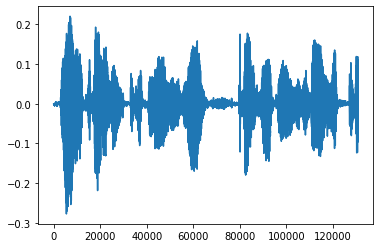

In [7]:
import torchaudio
import matplotlib.pyplot as plt
import torch
import torchaudio.functional as aF
audio_path = '/home/neoncloud/pix2pixHDAudioSR/test/test.wav'
metadata = torchaudio.info(audio_path)
print(metadata.num_frames)
audio, fs = torchaudio.load(audio_path)
K = 50000
audio_seg = audio[...,K:130816+K].squeeze()
print(audio_seg.mean())
plt.plot(audio_seg)
plt.show()

torch.Size([512, 256])
cuda:0


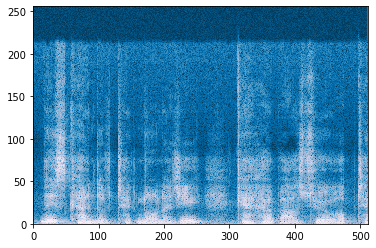

In [8]:
spectro, _ = fast_mdct(audio_seg.cuda().squeeze(0))
spectro_ = aF.amplitude_to_DB((spectro.abs().permute(1,0) + 1e-4),20,1e-4,1).squeeze(0)
print(spectro.size())
print(spectro.device)
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(spectro_.cpu().numpy(), cmap='PuBu_r')
plt.show()

tensor(-0.0001, device='cuda:0', dtype=torch.float64)
tensor(6.9826e-17, dtype=torch.float64)


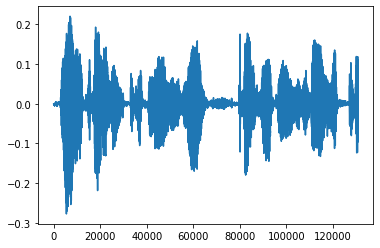

In [9]:
reconstruction, _ = imdct(spectro.unsqueeze(0))
err = (audio_seg.cpu().squeeze()[:130000] - reconstruction.squeeze().cpu()[:130000])**2
print(reconstruction.mean())
print(err.mean())
plt.plot(reconstruction.cpu().squeeze())
plt.show()

tensor(-0.0001, device='cuda:0', dtype=torch.float64)
tensor(6.9826e-17, dtype=torch.float64)


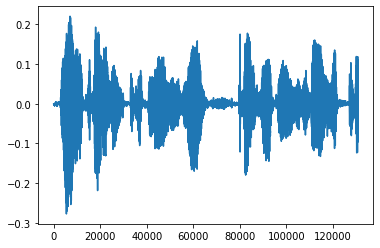

In [10]:
reconstruction, _ = fast_imdct(spectro.unsqueeze(0))
err = (audio_seg.cpu().squeeze()[:130000] - reconstruction.squeeze().cpu()[:130000])**2
print(reconstruction.mean())
print(err.mean())
plt.plot(reconstruction.cpu().squeeze())
plt.show()

In [ ]:
from models.mdct import IMDCT4
imdct_ = IMDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')

In [ ]:
reconstruction_, _ = imdct_(spectro.unsqueeze(0))
err = (audio_seg.cpu().squeeze()[:130000] - reconstruction_.squeeze().cpu()[:130000])**2
print(reconstruction_.mean())
print(err.mean())
plt.plot(reconstruction_.cpu().squeeze())
plt.show()

In [22]:
import timeit
from models.mdct import MDCT4, IMDCT4
N = 512
mdct = MDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')
fast_mdct = FastMDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')
a = torch.randn(64,1,32512).cuda()

In [23]:
%timeit for i in range(500): mdct(a)

788 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit for i in range(500): fast_mdct(a)

491 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
A,_ = mdct(a)
B,_ = fast_mdct(a)
(A-B).pow(2).sum()

tensor(9.2162e-06, device='cuda:0', dtype=torch.float64)

In [6]:
imdct = IMDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')
fast_imdct = FastIMDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')

In [13]:
a_, _ = imdct(A.squeeze())
b_, _ = fast_imdct(A.squeeze())
print((b_-a_).pow(2).sum())

tensor(5.6921e-22, device='cuda:0', dtype=torch.float64)


In [25]:
A = A.squeeze()
%timeit for i in range(500): imdct(A)

1.35 s ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit for i in range(500): fast_imdct(A)

813 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
